# Practical Pendulum

Biased implementations of popular RL algorithms on the classic Pendulum task. I've added some simple practical metrics that might help you _think_ more about what Deep RL is trying to do. You don't have to use them, they aren't theoretically packed, and in fact they probably aren't going to be advised by anyone else.

The following algorithms are implemented:

(Mostly) online algorithms:
- A2C
- PPO

(Mostly) offline algorithms:
- DDPG
- CRR
- AWR

These algorithms generally encompass most of Deep RL, except model-based approaches and other offline RL estimation algorithms like GenDICE, etc.

Some form of the above algorithms can be adjusted to implement just about any of the more niche or complicated extensions that exist out there:

- Residual gradients, etc. - Backprop through the target network in the TD.
- Impala, R2D2, etc. - Asynchronously collect data and train at the same time.
- GenDICE - Offline policy estimates
- Alpha* - Use a model of the environemnt or implicit bias.
- ... many more

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from functools import partial
from typing import NamedTuple, Union, Any, Tuple, Optional

# The Pendulum Problem

Inspired by the https://github.com/openai/gym/ pendulum implementation, let's simulate the Pendulum using TensorFlow, allowing us to produce many simulations in parallel, taking advantage of XLA and hardware acceleration.


In [3]:
class PendulumEnv:
    # Inspired by the https://github.com/openai/gym/ pendulum implementation.
    def __init__(self, g: float = 10., m: float = 1., l: float = 1.):
        self.g = g
        self.m = m
        self.l = l

    def get_initial_state_distribution(self) -> tfp.distributions.Uniform:
        """Returns a distribution of initial states."""
        max_initial_state = tf.constant([np.pi, 1.], tf.float32)
        distribution = tfp.distributions.Uniform(
            low=-max_initial_state,
            high=max_initial_state)
        return distribution

    @tf.function
    def transition(self, state: tf.Tensor, action: tf.Tensor, 
                   dt: Union[tf.Tensor, float] = 0.05) -> tf.Tensor:
        theta = state[..., 0]
        dtheta_dt = state[..., 1]
        u = tf.clip_by_value(tf.squeeze(action, axis=-1), -2., 2.)
        dtheta_dt_next = dtheta_dt + (
            (-3 * self.g / (2 * self.l) * tf.math.sin(theta + np.pi) + 3. / (self.m * self.l ** 2) * u) * dt)
        theta_next = theta + dtheta_dt_next * dt
        dtheta_dt_next = tf.clip_by_value(dtheta_dt_next, -8., 8.)
        next_state = tf.stack([theta_next, dtheta_dt_next], axis=-1)
        return next_state

    @tf.function
    def reward(self, state: tf.Tensor, action: tf.Tensor) -> tf.Tensor:
        theta = state[..., 0]
        dtheta_dt = state[..., 1]
        u = tf.clip_by_value(tf.squeeze(action, axis=-1), -2., 2.)
        normalized_theta = (((theta + np.pi) % (2 * np.pi)) - np.pi)
        theta_cost = normalized_theta ** 2
        u_cost = .001 * (u ** 2)
        dtheta_cost = .1 * dtheta_dt ** 2
        return -tf.stack([theta_cost, dtheta_cost, u_cost], axis=-1)

### Plots

Let's first simulate a few steps

In [4]:
mdp = PendulumEnv()
initial_state_distribution = mdp.get_initial_state_distribution()
action_distribtion = tfp.distributions.Uniform(low=tf.constant([-2.], tf.float32), 
                                               high=tf.constant([2.], tf.float32))
states = []
actions = []
state = initial_state_distribution.sample(1)
for _ in range(200):
    action = action_distribtion.sample(1)
    states.append(state.numpy())
    actions.append(action.numpy())
    state = mdp.transition(state, action)
states = np.concatenate(states, axis=0)
actions = np.concatenate(actions, axis=0)
rewards = mdp.reward(states, actions).numpy()

Let's plot what the dimensions of the Pendulum state looks like in over time. This is what our model will "see".

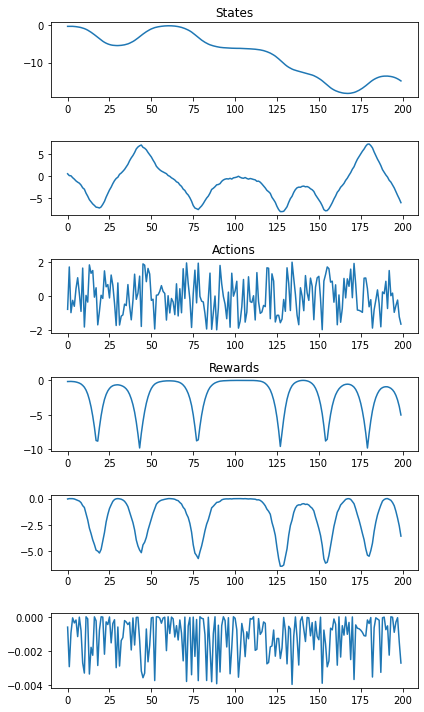

In [5]:
_, axes = plt.subplots(nrows=states.shape[-1] + 4, ncols=1, figsize=(6, 10))
state_axes = axes[:states.shape[-1]]
state_axes[0].set_title("States")
for i, ax in enumerate(state_axes):
    ax.plot(states[:, i])

action_ax = axes[states.shape[-1]]
action_ax.set_title("Actions")
action_ax.plot(actions[:, 0])

reward_axes = axes[states.shape[-1] + 1:]
reward_axes[0].set_title("Rewards")
for i, ax in enumerate(reward_axes):
    ax.plot(rewards[:, i])

plt.tight_layout()

# The Replay Buffer

We need to store the state over time (transitions). So we choose a buffer to store `Transition` data.

In [6]:
class Transition(NamedTuple):
    observation: tf.Tensor
    action: tf.Tensor
    reward: tf.Tensor
    next_observation: tf.Tensor
    next_action: tf.Tensor

def create_buffer(spec: tf.TensorSpec, size: int = 1):
    return tf.Variable(tf.zeros([size] + spec.shape.as_list(), spec.dtype), 
                       trainable=False)

class ReplayBuffer(tf.Module):
    def __init__(self, size: int, spec: Any):
        super().__init__()
        self.size = size
        self.spec = spec
        self.buffer = tf.nest.map_structure(partial(create_buffer, size=self.size), self.spec)
        self.count = tf.Variable(0, dtype=tf.int32, trainable=False)

    def add(self, buffer: tf.Variable, elements: tf.Tensor) -> tf.Variable:
        index = (self.count[None] + tf.range(tf.shape(elements)[0], dtype=tf.int32)) % self.size
        buffer.scatter_update(tf.IndexedSlices(elements, index))
        return buffer

    def update(self, transition: Transition) -> None:
        tf.nest.map_structure(self.add, self.buffer, transition)
        self.count.assign_add(tf.shape(transition.observation)[0])

    def get(self) -> Any:
        return tf.nest.map_structure(lambda x: tf.identity(x[:self.count]), 
                                     self.buffer)

    def dataset(self) -> tf.data.Dataset:
        return tf.data.Dataset.from_tensor_slices(self.get())

# Rollouts

Let's create some classes to generalize the agent, environment interaction, needlessly using TensorFlow 😅

In [7]:
class PendulumAgent:
    def observe(self, state: tf.Tensor) -> tf.Tensor:
        theta = state[..., 0]
        dtheta_dt = state[..., 1]
        return tf.stack([tf.math.cos(theta), tf.math.sin(theta), dtheta_dt], 
                        axis=-1)

    def act(self, observation: tf.Tensor) -> tf.Tensor:
        pass

class PendulumRollout:
    def __init__(self, env: PendulumEnv, agent: PendulumAgent):
        self.env = env
        self.agent = agent

    def unroll(self, initial_state: tf.Tensor, 
               num_steps: int) -> Tuple[tf.Tensor, tf.Tensor, Tuple[tf.Tensor, ...]]:
        observations = tf.TensorArray(tf.float32, size=num_steps) 
        actions = tf.TensorArray(tf.float32, size=num_steps)
        rewards = tf.TensorArray(tf.float32, size=num_steps)
        state = initial_state
        index = 0
        for index in tf.range(num_steps):
            observation = self.agent.observe(state)
            observations = observations.write(index, observation)
            action = self.agent.act(observation)
            actions = actions.write(index, action)
            reward = self.env.reward(state, action)
            rewards = rewards.write(index, reward)
            state = self.env.transition(state, action)
        next_observation = self.agent.observe(state)
        next_action = self.agent.act(next_observation)
        transition = Transition(
            observation=tf.transpose(observations.stack(), [1, 0, 2]), 
            action=tf.transpose(actions.stack(), [1, 0, 2]), 
            reward=tf.transpose(rewards.stack(), [1, 0, 2]), 
            next_observation=next_observation,
            next_action=next_action)
        return (state, transition)

### Plots

Let's record the agent's interaction with a simulated environment over time

In [8]:
class UniformPendulumAgent(PendulumAgent):
    def __init__(self):
        super().__init__()
        self.action_distribution = tfp.distributions.Uniform(low=tf.constant([-2.], tf.float32), 
                                                            high=tf.constant([2.], tf.float32))
    
    def act(self, observation: tf.Tensor) -> tf.Tensor:
        return self.action_distribution.sample(tf.shape(observation)[0])

mdp = PendulumEnv()
agent = UniformPendulumAgent()
rollout = PendulumRollout(mdp, agent)

initial_state = mdp.get_initial_state_distribution().sample(1)
final_state, transition = rollout.unroll(initial_state, 200)

Let's plot what the agent observed, how it acted, and the rewards it received over time.

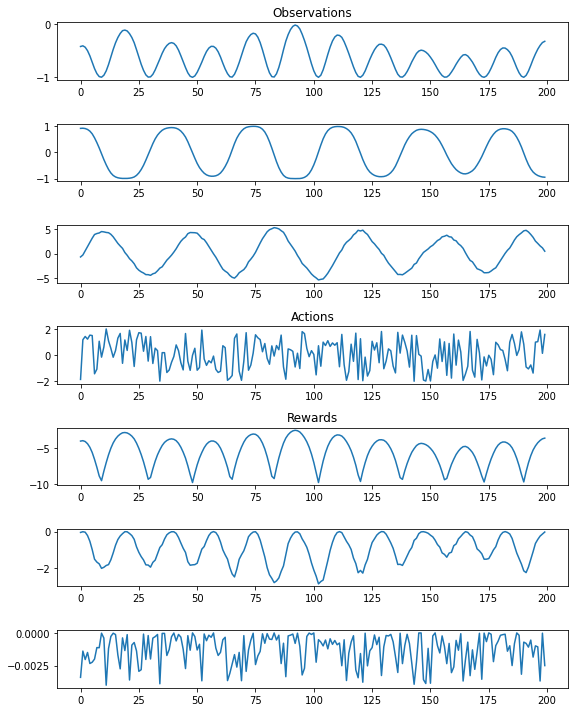

In [9]:
_, axes = plt.subplots(nrows=transition.observation.shape[-1] + 4, ncols=1, figsize=(8, 10))
observations_axes = axes[:transition.observation.shape[-1]]
observations_axes[0].set_title("Observations")
for i, ax in enumerate(observations_axes):
    ax.plot(transition.observation[0, :, i])

action_ax = axes[transition.observation.shape[-1]]
action_ax.set_title("Actions")
action_ax.plot(transition.action[0, :, 0])

reward_axes = axes[transition.observation.shape[-1] + 1:]
reward_axes[0].set_title("Rewards")
for i, ax in enumerate(reward_axes):
    ax.plot(transition.reward[0, :, i])

plt.tight_layout()

### Fill a replay buffer 

Let's try filling a replay buffer with some simulations just to check the logic.

In [10]:
# Store a single episode.
replay_buffer = ReplayBuffer(
    3, Transition(observation=tf.TensorSpec([200, 3]), 
                  action=tf.TensorSpec([200, 1]), 
                  reward=tf.TensorSpec([200, 3]), 
                  next_observation=tf.TensorSpec([3]),
                  next_action=tf.TensorSpec([1])))

initial_state = mdp.get_initial_state_distribution().sample(1)
final_state, transition = rollout.unroll(initial_state, 200)
replay_buffer.update(transition)
print(replay_buffer.get().observation.shape)

initial_state = mdp.get_initial_state_distribution().sample(2)
final_state, transition = rollout.unroll(initial_state, 200)
replay_buffer.update(transition)
print(replay_buffer.get().observation.shape)

(1, 200, 3)
(3, 200, 3)


# Policies and Agents

Let's create some classes to help us model and explore the optimal behavior of an agent better with neural networks.

In [11]:
class MVNPolicy(tf.Module):
    def __init__(self):
        super().__init__()
        self.hidden = tf.keras.layers.Dense(64, tf.nn.relu)
        self.shift = tf.keras.layers.Dense(1)
        self.scale_diag = tf.keras.layers.Dense(
            1, activation=lambda x: 1e-1 + tf.math.softplus(x))

    def conditional(self, observation: tf.Tensor, 
                    training: Optional[bool] = None) -> tfp.distributions.Distribution:
        hidden = self.hidden(observation, training=training)
        shift = self.shift(hidden, training=training)
        scale_diag = self.scale_diag(hidden, training=training)
        distribution = tfp.distributions.MultivariateNormalDiag(
            loc=shift, 
            scale_diag=scale_diag)
        return distribution

In [12]:
class ExplorePendulumAgent(PendulumAgent):
    def __init__(self, policy):
        super().__init__()
        self.policy = policy

    def act(self, observation: tf.Tensor) -> tf.Tensor:
        action_distribution = self.policy.conditional(observation, training=False)
        action = action_distribution.sample()
        return action

class ExploitPendulumAgent(PendulumAgent):
    def __init__(self, policy):
        super().__init__()
        self.policy = policy

    def act(self, observation: tf.Tensor) -> tf.Tensor:
        action_distribution = self.policy.conditional(observation, training=False)
        action = action_distribution.mode()
        return action

### Plots

Let's plot some of the prior actions that our agent will take without any optimization.

In [13]:
mdp = PendulumEnv()
policy = MVNPolicy()
agent = ExplorePendulumAgent(policy)
rollout = PendulumRollout(mdp, agent)

initial_state = mdp.get_initial_state_distribution().sample(2)
final_state, transition = rollout.unroll(initial_state, 200)

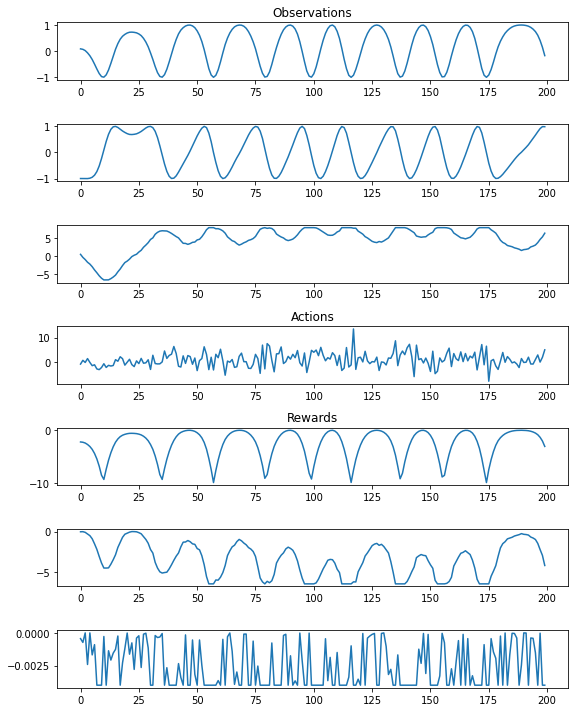

In [14]:
_, axes = plt.subplots(nrows=transition.observation.shape[-1] + 4, ncols=1, figsize=(8, 10))
observations_axes = axes[:transition.observation.shape[-1]]
observations_axes[0].set_title("Observations")
for i, ax in enumerate(observations_axes):
    ax.plot(transition.observation[0, :, i])

action_ax = axes[transition.observation.shape[-1]]
action_ax.set_title("Actions")
action_ax.plot(transition.action[0, :, 0])

reward_axes = axes[transition.observation.shape[-1] + 1:]
reward_axes[0].set_title("Rewards")
for i, ax in enumerate(reward_axes):
    ax.plot(transition.reward[0, :, i])

plt.tight_layout()

### Histogram of actions

(array([ 1.,  0.,  2.,  6., 11., 30., 43., 65., 67., 55., 38., 22., 19.,
        14.,  8.,  4.,  8.,  5.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-7.5775819e+00, -6.7347279e+00, -5.8918738e+00, -5.0490203e+00,
        -4.2061663e+00, -3.3633122e+00, -2.5204585e+00, -1.6776046e+00,
        -8.3475059e-01,  8.1032943e-03,  8.5095721e-01,  1.6938111e+00,
         2.5366650e+00,  3.3795190e+00,  4.2223730e+00,  5.0652266e+00,
         5.9080806e+00,  6.7509346e+00,  7.5937886e+00,  8.4366426e+00,
         9.2794962e+00,  1.0122350e+01,  1.0965204e+01,  1.1808058e+01,
         1.2650912e+01,  1.3493766e+01], dtype=float32),
 <a list of 25 Patch objects>)

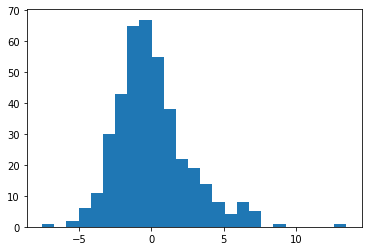

In [15]:
plt.hist(tf.reshape(transition.action, [-1]).numpy(), bins=25)

### Example fit

Let's try to fit the policy on it's own actions to test the logic.

In [16]:
optimizer = tf.keras.optimizers.SGD()
policy = MVNPolicy()
initial_sample_actions = policy.conditional(transition.observation).sample()
for _ in range(10):
    with tf.GradientTape() as tape:
        log_prob = policy.conditional(transition.observation).log_prob(transition.action)
        log_loss = -tf.reduce_mean(log_prob)
    gradients = tape.gradient(log_loss, policy.trainable_variables)
    global_norm = tf.linalg.global_norm(gradients)
    optimizer.apply_gradients(zip(gradients, policy.trainable_variables))
sample_actions = policy.conditional(transition.observation).sample()

(array([ 1.,  0.,  2.,  6., 11., 30., 43., 65., 67., 55., 38., 22., 19.,
        14.,  8.,  4.,  8.,  5.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-7.5775819e+00, -6.7347279e+00, -5.8918738e+00, -5.0490203e+00,
        -4.2061663e+00, -3.3633122e+00, -2.5204585e+00, -1.6776046e+00,
        -8.3475059e-01,  8.1032943e-03,  8.5095721e-01,  1.6938111e+00,
         2.5366650e+00,  3.3795190e+00,  4.2223730e+00,  5.0652266e+00,
         5.9080806e+00,  6.7509346e+00,  7.5937886e+00,  8.4366426e+00,
         9.2794962e+00,  1.0122350e+01,  1.0965204e+01,  1.1808058e+01,
         1.2650912e+01,  1.3493766e+01], dtype=float32),
 <a list of 25 Patch objects>)

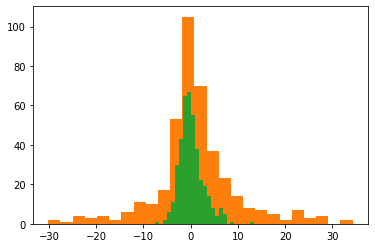

In [17]:
plt.hist(tf.reshape(initial_sample_actions, [-1]).numpy(), bins=25)
plt.hist(tf.reshape(sample_actions, [-1]).numpy(), bins=25)
plt.hist(tf.reshape(transition.action, [-1]).numpy(), bins=25)

### Values and returns

Let's introduce the concepts of returns, values, and bootstrapping to optimize our policies actions

In [18]:
def discounted_returns(rewards, discount=1., bootstrap_value=None):
    rewards_t = tf.transpose(rewards, [1, 0, 2])
    initial_value = None
    if bootstrap_value is not None:
        initial_value = bootstrap_value
    returns_t = tf.scan(lambda y, x: x + discount * y, rewards_t, reverse=True, 
                        initializer=initial_value)
    returns = tf.transpose(returns_t, [1, 0, 2])
    return returns

Let's plot what the discounted returns look like over time (without bootstrapping). The returns are gradually increasing because there less timesteps in the future that we have measured.

Bootstrapping allows us to estimate the continuing stream of rewards over the horizon that we might see in a non-episodic (continuing) environment like the pendulum.

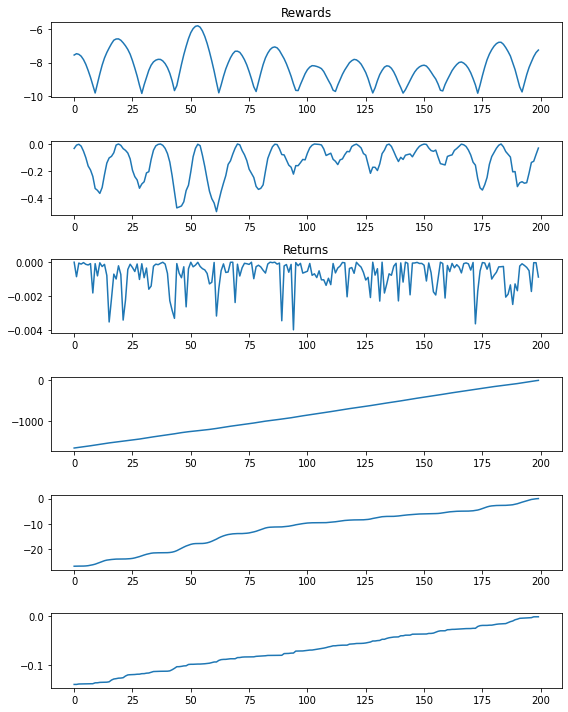

In [19]:
mdp = PendulumEnv()
agent = ExplorePendulumAgent(MVNPolicy())
rollout = PendulumRollout(mdp, agent)

initial_state = mdp.get_initial_state_distribution().sample(2)
final_state, transition = rollout.unroll(initial_state, 200)

returns = discounted_returns(transition.reward)

_, axes = plt.subplots(nrows=3 * 2, ncols=1, figsize=(8, 10))
axes[0].set_title("Rewards")
for i in range(3):
    axes[i].plot(transition.reward[0, :, i])

axes[i].set_title("Returns")
for i in range(3):
    axes[i + 3].plot(returns[0, :, i])
plt.tight_layout()

In [20]:
class Value(tf.Module):
    def __init__(self, num_values: int = 1):
        super().__init__()
        self.value = tf.keras.Sequential([
            tf.keras.layers.Dense(64, tf.nn.relu),
            tf.keras.layers.Dense(num_values)
        ])

    def __call__(self, inputs: tf.Tensor, 
                 training: Optional[bool] = None) -> tf.Tensor:
        return self.value(inputs, training=training)

### Example fit

Let's try to fit the value function on the computed returns (with bootstrapping).

#### Values

In [21]:
optimizer = tf.keras.optimizers.SGD()
state_value = Value(3)
# Can do the same for action values.
# action_value(tf.concat([transition.observation, transition.action], axis=-1))

n_step = 10
discount = 1 - (1 / n_step)
for _ in range(1000):
    with tf.GradientTape() as tape:
        values = state_value(transition.observation)
        next_observations = tf.concat(
            [transition.observation[:, 1:], transition.next_observation[:, None]], axis=1)
        # Don't stop gradient for RG.
        bootstrap_values = tf.stop_gradient(state_value(next_observations))
        td_error = transition.reward + discount * bootstrap_values - values
        value_loss = tf.reduce_mean(td_error ** 2) * 0.5
    gradients = tape.gradient(value_loss, state_value.trainable_variables)
    optimizer.apply_gradients(zip(gradients, state_value.trainable_variables))
values = state_value(transition.observation)
n_step_undiscounted_returns = tf.reduce_sum(
    tf.signal.frame(transition.reward, n_step, 1, pad_end=True, axis=1), axis=2)

Plot a histogram of the predicted discounted returns (value) and the n-step undiscounted returns. 

The n-step undiscounted returns (without bootstrapping) should give us an accurate estimate of the true value of the policy. Since we are predicting the discounted return with a discount factor equal to `1 - (1 / n-step)`, our value should be a good estimator of the n-step undiscounted return.

The fit will be good if the signals are significantly correlated. The last signal ("torque" cost) is hard to predict, not only because we are estimating the state-value (the {state}) cost and not the action-value (the {state, action} tuple) cost here, but because it's just difficult to predict exactly what actions the policy will be taking in the future, and on such a small magnitude.


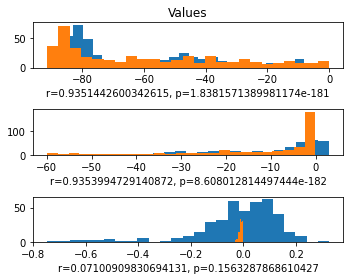

In [22]:
from scipy.stats import linregress

np_values = tf.reshape(values, [-1, 3]).numpy()
np_n_step_undiscounted_returns = tf.reshape(n_step_undiscounted_returns, [-1, 3]).numpy()

results = []
for i in range(3):
    result = linregress(np_values[:, i], np_n_step_undiscounted_returns[:, i])
    results.append(result)

f, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 4))
axes[0].set_title("Values")
for i in range(3):
    axes[i].hist(np_values[:, i], bins=25)
    axes[i].hist(np_n_step_undiscounted_returns[:, i], bins=25)
    axes[i].set_xlabel(f"r={results[i].rvalue}, p={results[i].pvalue}")
plt.tight_layout()

# Algorithms

### Utilities

In [23]:
def assign_variables(destination, source, tau=None):
    for dst, src in zip(destination.variables, 
                        source.variables):
        if tau is None:
            dst.assign(src)
        else:
            dst.assign(dst * (1. - tau) + src * tau)

def weighted_mean(x, w, sample_axis=0):
    return tf.reduce_sum(x * w, axis=sample_axis) / tf.reduce_sum(w, axis=sample_axis)

def covariance(x, y, w, sample_axis=0):
    x_mean = weighted_mean(x, w, sample_axis=sample_axis)
    y_mean = weighted_mean(y, w, sample_axis=sample_axis)
    return weighted_mean((x - x_mean) * (y - y_mean), w, sample_axis=sample_axis)

def weighted_correlation(x, y, w, sample_axis=0):
    x_y_cov = covariance(x, y, w, sample_axis=sample_axis)
    x_x_cov = covariance(x, x, w, sample_axis=sample_axis)
    y_y_cov = covariance(y, y, w, sample_axis=sample_axis)
    return x_y_cov / tf.sqrt(x_x_cov * y_y_cov)

def scale(x, axis=0):
    x_min = tf.reduce_min(x, axis=axis)
    x_max = tf.reduce_max(x, axis=axis)
    return (x - x_min) / (x_max - x_min)

## A2C
A few "tricks" (these aren't generally applicable in practice, TBH) to improve stability:
1. Clip advantages within -1., 1. This prevents _exploding_ gradients and mitigates some issues under/overestimation of the returns and reduces variance, but introduces bias.
2. Don't overfit the policy to prevent massive log probabilities and exploding gradients. The log probability can easily overfit when on-policy and the normal distribution collapses, making it absurdly too certain about the actions it's taking.

In [ ]:
class A2C:
    def __init__(self, policy, value, replay_buffer, num_value_steps: int, 
                 num_policy_steps: int, alpha: float, discount: float, batch_size: int):
        self.batch_size = batch_size
        self.num_value_steps = tf.constant(num_value_steps, tf.int64)
        self.num_policy_steps = tf.constant(num_policy_steps, tf.int64)
        self.alpha = tf.constant(alpha)
        self.discount = tf.constant(discount)
        self.mse = tf.keras.losses.MeanSquaredError()
        self.policy_optimizer = tf.keras.optimizers.Adam()
        self.value_optimizer = tf.keras.optimizers.Adam()
        self.policy = policy
        self.value = value
        self.replay_buffer = replay_buffer

    def initialize(self) -> None:
        observations = tf.zeros([1, 3], tf.float32)
        self.policy.conditional(observations)
        self.value(observations)

    def update(self) -> None:
        replay_dataset = self.replay_buffer.dataset()
        replay_dataset_value = (
            replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(-1))
        replay_dataset_value_iter = iter(replay_dataset_value)
        replay_dataset_policy = (
            replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(-1))
        replay_dataset_policy_iter = iter(replay_dataset_policy)

        # Fit the value
        for _ in tf.range(self.num_value_steps):
            (observations, actions, rewards, next_observation, _) = next(
                replay_dataset_value_iter)

            # Compute returns
            next_observations = tf.concat([observations[:, 1:], next_observation[:, None]], axis=1)
            bootstrap_values = self.value(next_observations)
            returns = tf.reduce_sum(rewards, axis=-1)[..., None] + self.discount * bootstrap_values

            with tf.GradientTape() as tape:
                values = self.value(observations, training=tf.constant(True))
                value_loss = .5 * self.mse(returns, values)
            value_gradients = tape.gradient(value_loss, 
                                            self.value.trainable_variables)
            self.value_optimizer.apply_gradients(
                zip(value_gradients, self.value.trainable_variables))

        # Fit the policy
        for _ in tf.range(self.num_policy_steps):
            (observations, actions, rewards, next_observation, _) = next(replay_dataset_policy_iter)

            next_observations = tf.concat([observations[:, 1:], next_observation[:, None]], axis=1)
            bootstrap_values = self.value(next_observations)
            returns = tf.reduce_sum(rewards, axis=-1)[..., None] + self.discount * bootstrap_values

            # Compute advantages
            values = self.value(observations)
            advantages = tf.squeeze(returns - values, axis=-1)

            # These tend to be exploding, so we clip.
            advantages = tf.clip_by_value(advantages, -1., 1.)

            with tf.GradientTape() as tape:
                distribution = self.policy.conditional(
                    observations, 
                    training=tf.constant(True))
                log_prob = distribution.log_prob(actions)
                score = log_prob * advantages
                entropy = tf.reduce_mean(distribution.entropy())
                policy_loss = -(tf.reduce_mean(score) + self.alpha * entropy)
            policy_gradients = tape.gradient(policy_loss, 
                                             self.policy.trainable_variables)
            self.policy_optimizer.apply_gradients(
                zip(policy_gradients, self.policy.trainable_variables))

        # Metrics.
        (observations, actions, rewards, next_observation, _) = self.replay_buffer.get()
        next_observations = tf.concat([observations[:, 1:], next_observation[:, None]], axis=1)
        bootstrap_values = self.value(next_observations)
        returns = tf.reduce_sum(rewards, axis=-1)[..., None] + self.discount * bootstrap_values

        # Compute advantages
        values = self.value(observations)
        advantages = tf.squeeze(returns - values, axis=-1)

        # These tend to be exploding, so we clip.
        advantages = tf.clip_by_value(advantages, -1., 1.)

        # Measure weighted correlation.
        distribution = self.policy.conditional(observations, training=tf.constant(False))
        policy_actions = distribution.mode()
        policy_correlation = weighted_correlation(
            tf.squeeze(actions, axis=-1), 
            tf.squeeze(policy_actions, axis=-1), 
            scale(advantages, axis=[0, 1]), 
            sample_axis=[0, 1])

        average_value = tf.reduce_mean(values)
        average_returns = tf.reduce_mean(tf.reduce_sum(rewards, axis=[1, 2]), axis=0)

        return average_value, average_returns, policy_correlation            

### Fit

In [ ]:
batch_size = 32
n_step = 50
replay_buffer = ReplayBuffer(
    batch_size, Transition(
        observation=tf.TensorSpec([n_step, 3]), 
        action=tf.TensorSpec([n_step, 1]), 
        reward=tf.TensorSpec([n_step, 3]), 
        next_observation=tf.TensorSpec([3]),
        next_action=tf.TensorSpec([1], tf.float32)))
mdp = PendulumEnv()
policy = MVNPolicy()
value = Value()

discount = 1 - (1 / n_step)
a2c = A2C(policy, value, replay_buffer, 200, 1, 0.0, discount, batch_size)
a2c.update = tf.function(a2c.update)

reset_every = 200 // n_step
explore_agent = ExplorePendulumAgent(policy)
exploit_agent = ExploitPendulumAgent(policy)
explore_rollout = PendulumRollout(mdp, explore_agent)
explore_rollout.unroll = tf.function(explore_rollout.unroll)
exploit_rollout = PendulumRollout(mdp, exploit_agent)
exploit_rollout.unroll = tf.function(exploit_rollout.unroll)

valid_state = mdp.get_initial_state_distribution().sample(100)
state = mdp.get_initial_state_distribution().sample(batch_size)

metrics = {
    "Returns": [],
    "Value Correlation": [],
    "Average Value": [],
    "Average Returns": [],
    "Policy Correlation": [],
}

for i in range(500):
    state, transition = explore_rollout.unroll(state, n_step)
    if (i + 1) % reset_every == 0:
        state = mdp.get_initial_state_distribution().sample(batch_size)
    replay_buffer.update(transition)
    average_value, average_returns, policy_correlation = a2c.update()
    _, transition = explore_rollout.unroll(valid_state, 200)

    # Output some metrics.
    reward = tf.reduce_sum(transition.reward, axis=-1)
    returns = tf.reduce_mean(tf.reduce_sum(reward, axis=1), axis=0).numpy()
    n_step_undiscounted_returns = tf.reduce_sum(
        tf.signal.frame(reward, n_step, 1, pad_end=True, axis=1), axis=2)
    n_step_undiscounted_returns = tf.reshape(n_step_undiscounted_returns, [-1])
    values = tf.reshape(value(transition.observation), [-1])
    value_correlation = tfp.stats.correlation(values, n_step_undiscounted_returns, sample_axis=0, event_axis=None).numpy()
    print(f"G={returns},r={value_correlation}")

    metrics["Returns"].append(returns)
    metrics["Value Correlation"].append(value_correlation)
    metrics["Average Value"].append(average_value)
    metrics["Average Returns"].append(average_returns)
    metrics["Policy Correlation"].append(policy_correlation)

G=-1551.0106201171875,r=-0.017879048362374306
G=-1569.673095703125,r=-0.0028394267428666353
G=-1582.4627685546875,r=0.013692663982510567
G=-1587.8616943359375,r=0.04051278159022331
G=-1599.3673095703125,r=0.036141932010650635
G=-1613.9228515625,r=0.06893997639417648
G=-1618.4488525390625,r=0.07840478420257568
G=-1617.7001953125,r=0.08484026789665222
G=-1609.5189208984375,r=0.11751237511634827
G=-1605.0947265625,r=0.10191649198532104
G=-1596.9710693359375,r=0.10014250129461288
G=-1579.575927734375,r=0.13240189850330353
G=-1571.727294921875,r=0.11597049236297607
G=-1559.171142578125,r=0.1352909952402115
G=-1547.5635986328125,r=0.13301993906497955
G=-1533.8935546875,r=0.16862495243549347
G=-1513.0753173828125,r=0.14705917239189148
G=-1474.7451171875,r=0.24590346217155457
G=-1458.0469970703125,r=0.24112680554389954
G=-1433.883544921875,r=0.2680663466453552
G=-1418.608154296875,r=0.3007192611694336
G=-1391.7548828125,r=0.3667861223220825
G=-1346.052978515625,r=0.4301348626613617
G=-1319.892

### Analysis of the fit

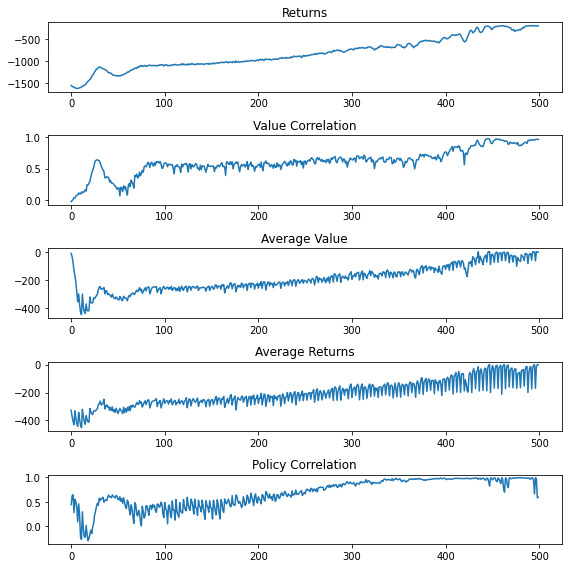

In [ ]:
f, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 8))
for i, (key, value) in enumerate(metrics.items()):
    axes[i].plot(value)
    axes[i].set_title(key)
plt.tight_layout()

## PPO

In [ ]:

class PPO:
    def __init__(self, policy, target_policy, value, replay_buffer,
                 num_value_steps: int, num_policy_steps: int, 
                 alpha: float, epsilon: float, 
                 discount: float, batch_size: int):
        self.replay_buffer = replay_buffer
        self.batch_size = batch_size
        self.num_value_steps = tf.constant(num_value_steps, tf.int64)
        self.num_policy_steps = tf.constant(num_policy_steps, tf.int64)
        self.alpha = tf.constant(alpha)
        self.epsilon = tf.constant(epsilon)
        self.discount = tf.constant(discount)
        self.policy = policy
        self.target_policy = target_policy
        self.value = value
        self.mse = tf.keras.losses.MeanSquaredError()
        self.policy_optimizer = tf.keras.optimizers.Adam()
        self.value_optimizer = tf.keras.optimizers.Adam()

    def initialize(self) -> None:
        observations = tf.zeros([1, 3], tf.float32)
        self.policy.conditional(observations)
        self.target_policy.conditional(observations)
        assign_variables(self.target_policy, self.policy)   
        self.value(observations)

    def update(self) -> None:
        assign_variables(self.target_policy, self.policy)

        replay_dataset = self.replay_buffer.dataset()
        replay_dataset_value = (
            replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
            .repeat(-1)
            .batch(self.batch_size)
            .prefetch(-1))
        replay_dataset_value_iter = iter(replay_dataset_value)
        replay_dataset_policy = (
            replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
            .repeat(-1)
            .batch(self.batch_size)
            .prefetch(-1))
        replay_dataset_policy_iter = iter(replay_dataset_policy)

        # Fit the value
        for _ in tf.range(self.num_value_steps):
            (observations, actions, rewards, next_observation, _) = next(replay_dataset_value_iter)

            # Compute returns
            next_observations = tf.concat([observations[:, 1:], next_observation[:, None]], axis=1)
            bootstrap_values = self.value(next_observations)
            returns = tf.reduce_sum(rewards, axis=-1)[..., None] + self.discount * bootstrap_values

            with tf.GradientTape() as tape:
                values = self.value(observations, training=tf.constant(True))
                value_loss = .5 * self.mse(returns, values)
            value_gradients = tape.gradient(value_loss, 
                                            self.value.trainable_variables)
            self.value_optimizer.apply_gradients(
                zip(value_gradients, self.value.trainable_variables))

        for _ in tf.range(self.num_policy_steps):
            (observations, actions, rewards, next_observation, _) = next(replay_dataset_policy_iter)

            # Compute returns
            next_observations = tf.concat([observations[:, 1:], next_observation[:, None]], axis=1)
            bootstrap_values = self.value(next_observations)
            returns = tf.reduce_sum(rewards, axis=-1)[..., None] + self.discount * bootstrap_values

            # Compute advantages
            values = self.value(observations)
            advantages = tf.squeeze(returns - values, axis=-1)
        
            # These tend to be exploding, so we clip.
            advantages = tf.clip_by_value(advantages, -1., 1.)

            # Fit the policy
            distribution_prior = self.target_policy.conditional(observations)
            log_prob_prior = distribution_prior.log_prob(actions)

            with tf.GradientTape() as tape:
                distribution = self.policy.conditional(
                    observations, 
                    training=tf.constant(True))
                log_prob = distribution.log_prob(actions)
                ratio = tf.exp(log_prob - log_prob_prior)
                ratio = tf.where(tf.math.is_nan(ratio), 0., ratio)
                score = tf.minimum(
                    ratio * advantages,
                    tf.clip_by_value(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages)
                entropy = tf.reduce_mean(distribution.entropy())
                policy_loss = -(tf.reduce_mean(score) + self.alpha * entropy)
            policy_gradients = tape.gradient(policy_loss, 
                                             self.policy.trainable_variables)
            self.policy_optimizer.apply_gradients(
                zip(policy_gradients, self.policy.trainable_variables))

        # Metrics.
        (observations, actions, rewards, next_observation, _) = self.replay_buffer.get()
        next_observations = tf.concat([observations[:, 1:], next_observation[:, None]], axis=1)
        bootstrap_values = self.value(next_observations)
        returns = tf.reduce_sum(rewards, axis=-1)[..., None] + self.discount * bootstrap_values

        # Compute advantages
        values = self.value(observations)
        advantages = tf.squeeze(returns - values, axis=-1)

        # These tend to be exploding, so we clip.
        advantages = tf.clip_by_value(advantages, -1., 1.)

        # Measure weighted correlation.
        distribution = self.policy.conditional(observations, training=tf.constant(False))
        policy_actions = distribution.mode()
        policy_correlation = weighted_correlation(
            tf.squeeze(actions, axis=-1), 
            tf.squeeze(policy_actions, axis=-1), 
            scale(advantages, axis=[0, 1]), 
            sample_axis=[0, 1])

        average_value = tf.reduce_mean(values)
        average_returns = tf.reduce_mean(tf.reduce_sum(rewards, axis=[1, 2]), axis=0)

        return average_value, average_returns, policy_correlation 

### Fit

In [ ]:
batch_size = 32
n_step = 50
replay_buffer = ReplayBuffer(
    batch_size, Transition(
        observation=tf.TensorSpec([n_step, 3]), 
        action=tf.TensorSpec([n_step, 1]), 
        reward=tf.TensorSpec([n_step, 3]), 
        next_observation=tf.TensorSpec([3]),
        next_action=tf.TensorSpec([1], tf.float32)))
mdp = PendulumEnv()
policy = MVNPolicy()
target_policy = MVNPolicy()
value = Value()

discount = 1 - (1 / n_step)
ppo = PPO(policy, target_policy, value, replay_buffer, 200, 50, 0.0, 0.2, discount, batch_size)
ppo.update = tf.function(ppo.update)

reset_every = 200 // n_step
explore_agent = ExplorePendulumAgent(policy)
exploit_agent = ExploitPendulumAgent(policy)
explore_rollout = PendulumRollout(mdp, explore_agent)
explore_rollout.unroll = tf.function(explore_rollout.unroll)
exploit_rollout = PendulumRollout(mdp, exploit_agent)
exploit_rollout.unroll = tf.function(exploit_rollout.unroll)

valid_state = mdp.get_initial_state_distribution().sample(100)
state = mdp.get_initial_state_distribution().sample(batch_size)

metrics = {
    "Returns": [],
    "Value Correlation": [],
    "Average Value": [],
    "Average Returns": [],
    "Policy Correlation": [],
}

for i in range(1000):
    state, transition = explore_rollout.unroll(state, n_step)
    if (i + 1) % reset_every == 0:
        state = mdp.get_initial_state_distribution().sample(batch_size)
    replay_buffer.update(transition)
    average_value, average_returns, policy_correlation = ppo.update()
    _, transition = explore_rollout.unroll(valid_state, 200)

    # Output some metrics.
    reward = tf.reduce_sum(transition.reward, axis=-1)
    returns = tf.reduce_mean(tf.reduce_sum(reward, axis=1), axis=0).numpy()
    n_step_undiscounted_returns = tf.reduce_sum(
        tf.signal.frame(reward, n_step, 1, pad_end=True, axis=1), axis=2)
    n_step_undiscounted_returns = tf.reshape(n_step_undiscounted_returns, [-1])
    values = tf.reshape(value(transition.observation), [-1])
    value_correlation = tfp.stats.correlation(values, n_step_undiscounted_returns, sample_axis=0, event_axis=None).numpy()
    print(f"G={returns},r={value_correlation}")

    metrics["Returns"].append(returns)
    metrics["Value Correlation"].append(value_correlation)
    metrics["Average Value"].append(average_value)
    metrics["Average Returns"].append(average_returns)
    metrics["Policy Correlation"].append(policy_correlation)

G=-1378.26416015625,r=-0.10365226119756699
G=-1398.5506591796875,r=-0.09526699036359787
G=-1434.131103515625,r=-0.09414248913526535
G=-1500.4881591796875,r=-0.06811206787824631
G=-1522.9365234375,r=-0.037415117025375366
G=-1528.82177734375,r=0.0946066826581955
G=-1470.22509765625,r=0.20650897920131683
G=-1355.529052734375,r=0.25444746017456055
G=-1274.37646484375,r=0.2714807391166687
G=-1220.1395263671875,r=0.26624369621276855
G=-1181.6151123046875,r=0.27508997917175293
G=-1142.15087890625,r=0.2619478404521942
G=-1102.2164306640625,r=0.20073199272155762
G=-1088.366455078125,r=0.26501816511154175
G=-1137.0157470703125,r=0.2489221692085266
G=-1188.44482421875,r=0.20003102719783783
G=-1231.799560546875,r=0.14923450350761414
G=-1210.03564453125,r=0.21884626150131226
G=-1189.9320068359375,r=0.15643127262592316
G=-1177.4776611328125,r=0.14086228609085083
G=-1146.8460693359375,r=0.25369468331336975
G=-1141.11474609375,r=0.23468701541423798
G=-1117.9102783203125,r=0.21083347499370575
G=-1086.2

### Analysis of the fit

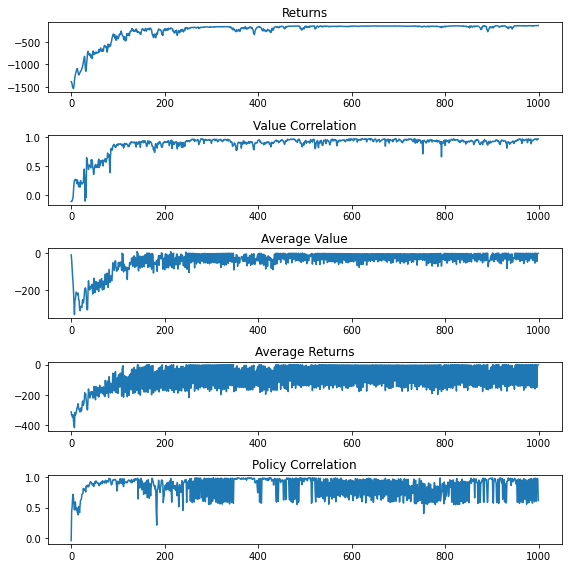

In [ ]:
f, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 8))
for i, (key, value) in enumerate(metrics.items()):
    axes[i].plot(value)
    axes[i].set_title(key)
plt.tight_layout()

## DDPG

In [ ]:
class DDPG:
    def __init__(self, policy, target_policy, value, target_value, 
                 replay_buffer, num_value_steps: int, num_policy_steps: int, alpha: float, 
                 tau: float, discount: float, batch_size: int):
        self.batch_size = tf.constant(batch_size, tf.int64)
        self.num_value_steps = tf.constant(num_value_steps, tf.int64)
        self.num_policy_steps = tf.constant(num_policy_steps, tf.int64)
        self.alpha = tf.constant(alpha)
        self.tau = tf.constant(tau)
        self.discount = tf.constant(discount)
        self.policy = policy
        self.target_policy = target_policy
        self.value = value
        self.target_value = target_value
        self.mse = tf.keras.losses.MeanSquaredError()
        self.policy_optimizer = tf.keras.optimizers.Adam()
        self.value_optimizer = tf.keras.optimizers.Adam()
        self.replay_buffer = replay_buffer

    def initialize(self) -> None:
        observations = tf.zeros([1, 3], tf.float32)
        actions = tf.zeros([1, 1], tf.float32)
        observations_actions = tf.concat([observations, actions], axis=-1)
        self.policy.conditional(observations)
        self.target_policy.conditional(observations)
        assign_variables(self.target_policy, self.policy)
        self.value(observations_actions)
        self.target_value(observations_actions)
        assign_variables(self.target_value, self.value)        

    def update(self) -> None:
        if tf.cast(self.replay_buffer.count, tf.int64) >= self.batch_size:
            replay_dataset = self.replay_buffer.dataset()
            replay_dataset_value = (
                replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
                .repeat(-1)
                .batch(self.batch_size)
                .prefetch(-1))
            replay_dataset_value_iter = iter(replay_dataset_value)
            replay_dataset_policy = (
                replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
                .repeat(-1)
                .batch(self.batch_size)
                .prefetch(-1))
            replay_dataset_policy_iter = iter(replay_dataset_policy)

            # Fit the value
            for _ in tf.range(self.num_value_steps):
                (observations, actions, rewards, next_observation, 
                next_action) = next(replay_dataset_value_iter)

                # Compute targets
                next_observations = tf.concat(
                    [observations[:, 1:], next_observation[:, None]], axis=1)
                target_distribution = self.target_policy.conditional(
                    next_observations)
                next_actions = target_distribution.sample()
                next_observations_next_actions = tf.concat(
                    [next_observations, next_actions], axis=-1)
                bootstrap_value = self.target_value(
                    next_observations_next_actions)
                targets = (
                    tf.reduce_sum(rewards, axis=-1)[..., None] + (
                        self.discount * bootstrap_value))

                observations_actions = tf.concat([observations, actions], 
                                                 axis=-1)
                with tf.GradientTape(persistent=True) as tape:
                    values = self.value(observations_actions, 
                                        training=tf.constant(True))
                    value_loss = .5 * self.mse(targets, values)
                value_gradients = tape.gradient(value_loss, 
                                                self.value.trainable_variables)
                self.value_optimizer.apply_gradients(
                    zip(value_gradients, self.value.trainable_variables))
                assign_variables(self.target_value, self.value, tau=self.tau)

            # Fit the policy
            for _ in tf.range(self.num_policy_steps):
                (observations, actions, rewards, next_observation, 
                next_action) = next(replay_dataset_policy_iter)

                with tf.GradientTape(persistent=True) as tape:
                    distribution = self.policy.conditional(
                        observations, 
                        training=tf.constant(True))
                    policy_actions = distribution.sample()
                    entropy_loss = -tf.reduce_mean(
                        distribution.entropy())
                    observations_policy_actions = tf.concat(
                        [observations, policy_actions], axis=-1)
                    policy_loss = -tf.reduce_mean(self.value(
                        observations_policy_actions))
                    policy_loss += self.alpha * entropy_loss
                policy_gradients = tape.gradient(policy_loss, 
                                                 self.policy.trainable_variables)
                self.policy_optimizer.apply_gradients(
                    zip(policy_gradients, self.policy.trainable_variables))
                assign_variables(self.target_policy, self.policy, tau=self.tau)

        # Metrics.
        (observations, actions, rewards, next_observation, next_action) = self.replay_buffer.get()
        next_observations = tf.concat(
            [observations[:, 1:], next_observation[:, None]], axis=1)
        target_distribution = self.target_policy.conditional(
            next_observations)
        next_actions = target_distribution.sample()
        next_observations_next_actions = tf.concat(
            [next_observations, next_actions], axis=-1)
        bootstrap_value = self.target_value(
            next_observations_next_actions)
        returns = (
            tf.reduce_sum(rewards, axis=-1)[..., None] + (
                self.discount * bootstrap_value))
        observations_actions = tf.concat([observations, actions], 
                                            axis=-1)
        values = self.value(observations_actions)

        # Compute advantages
        advantages = tf.squeeze(returns - values, axis=-1)

        # These tend to be exploding, so we clip.
        advantages = tf.clip_by_value(advantages, -1., 1.)

        # Measure weighted correlation.
        distribution = self.policy.conditional(observations, training=tf.constant(False))
        policy_actions = distribution.mode()
        policy_correlation = weighted_correlation(
            tf.squeeze(actions, axis=-1), 
            tf.squeeze(policy_actions, axis=-1), 
            scale(advantages, axis=[0, 1]), 
            sample_axis=[0, 1])

        average_value = tf.reduce_mean(values)
        average_returns = tf.reduce_mean(tf.reduce_sum(rewards, axis=[1, 2]), axis=0)

        return average_value, average_returns, policy_correlation

### Fit

In [ ]:
batch_size = 250
n_step = 50
replay_buffer = ReplayBuffer(
    10000, Transition(
        observation=tf.TensorSpec([n_step, 3]), 
        action=tf.TensorSpec([n_step, 1]), 
        reward=tf.TensorSpec([n_step, 3]), 
        next_observation=tf.TensorSpec([3]), 
        next_action=tf.TensorSpec([1], tf.float32)))
mdp = PendulumEnv()
policy = MVNPolicy()
target_policy = MVNPolicy()
value = Value()
target_value = Value()

discount = 1 - (1 / n_step)
agent = DDPG(policy, target_policy, value, target_value, replay_buffer, 50, 50, 0.001, 0.001, discount, batch_size)
agent.update = tf.function(agent.update)

reset_every = 200 // n_step
explore_agent = ExplorePendulumAgent(policy)
exploit_agent = ExploitPendulumAgent(policy)
explore_rollout = PendulumRollout(mdp, explore_agent)
explore_rollout.unroll = tf.function(explore_rollout.unroll)
exploit_rollout = PendulumRollout(mdp, exploit_agent)
exploit_rollout.unroll = tf.function(exploit_rollout.unroll)

valid_state = mdp.get_initial_state_distribution().sample(100)
state = mdp.get_initial_state_distribution().sample(batch_size)

metrics = {
    "Returns": [],
    "Value Correlation": [],
    "Average Value": [],
    "Average Returns": [],
    "Policy Correlation": [],
}

for i in range(1000):
    state, transition = explore_rollout.unroll(state, n_step)
    if (i + 1) % reset_every == 0:
        state = mdp.get_initial_state_distribution().sample(batch_size)
    replay_buffer.update(transition)
    average_value, average_returns, policy_correlation = agent.update()
    _, transition = explore_rollout.unroll(valid_state, 200)

    # Output some metrics.
    reward = tf.reduce_sum(transition.reward, axis=-1)
    returns = tf.reduce_mean(tf.reduce_sum(reward, axis=1), axis=0).numpy()
    n_step_undiscounted_returns = tf.reduce_sum(
        tf.signal.frame(reward, n_step, 1, pad_end=True, axis=1), axis=2)
    n_step_undiscounted_returns = tf.reshape(n_step_undiscounted_returns, [-1])
    values = tf.reshape(value(tf.concat([transition.observation, transition.action], axis=-1)), [-1])
    value_correlation = tfp.stats.correlation(values, n_step_undiscounted_returns, sample_axis=0, event_axis=None).numpy()
    print(f"G={returns},r={value_correlation}")

    metrics["Returns"].append(returns)
    metrics["Value Correlation"].append(value_correlation)
    metrics["Average Value"].append(average_value)
    metrics["Average Returns"].append(average_returns)
    metrics["Policy Correlation"].append(policy_correlation)

G=-1795.79833984375,r=0.07079900801181793
G=-1839.712158203125,r=0.08227208256721497
G=-1776.2198486328125,r=0.08697163313627243
G=-1671.9715576171875,r=0.06176576018333435
G=-1439.03857421875,r=-0.015543298795819283
G=-1383.1507568359375,r=0.07505079358816147
G=-1475.0418701171875,r=0.07337911427021027
G=-1505.93310546875,r=0.06474234908819199
G=-1491.7601318359375,r=0.06250040233135223
G=-1461.58837890625,r=0.06560511142015457
G=-1426.58203125,r=0.06357572227716446
G=-1400.6640625,r=0.05532381683588028
G=-1373.3629150390625,r=0.05875157564878464
G=-1362.15625,r=0.05513140931725502
G=-1358.9453125,r=0.05103268101811409
G=-1359.756591796875,r=0.05194767937064171
G=-1374.924072265625,r=0.04757453501224518
G=-1395.3818359375,r=0.04284379258751869
G=-1411.3203125,r=0.04549071937799454
G=-1424.4957275390625,r=0.04937091842293739
G=-1437.8262939453125,r=0.045283976942300797
G=-1451.7991943359375,r=0.041661396622657776
G=-1462.07568359375,r=0.040337901562452316
G=-1472.87060546875,r=0.039000

### Analysis of the fit

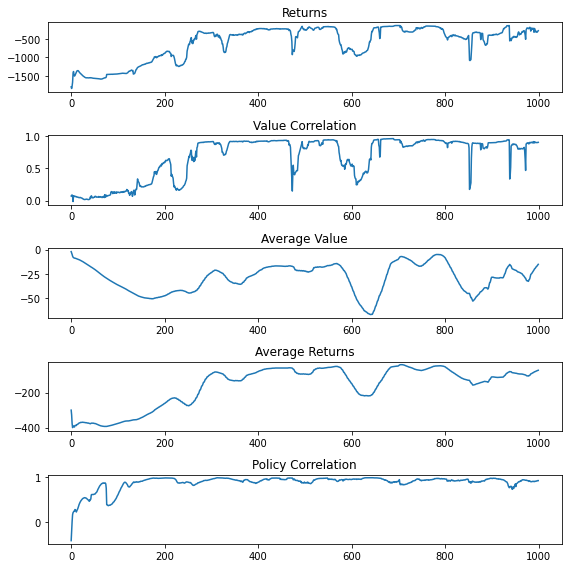

In [ ]:
f, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 8))
for i, (key, value) in enumerate(metrics.items()):
    axes[i].plot(value)
    axes[i].set_title(key)
plt.tight_layout()

## CRR

Critic Regularized Regression - an offline reinforcement learning algorithm that is suprisingly stable! Use this if you have a large dataset and don't have access to the policy (and it's probabilities) that collected the data.

In [ ]:
class CRR:
    def __init__(self, policy, target_policy, value, target_value, 
                 replay_buffer, num_policy_value_steps: int, alpha: float, 
                 tau: float, discount: float, num_samples: int, 
                 batch_size: int):
        super().__init__()
        self.replay_buffer = replay_buffer
        self.num_samples = tf.constant(num_samples)
        self.batch_size = tf.constant(batch_size, tf.int64)
        self.num_policy_value_steps = tf.constant(num_policy_value_steps, tf.int64)
        self.alpha = tf.constant(alpha)
        self.tau = tf.constant(tau)
        self.discount = tf.constant(discount)
        self.policy = policy
        self.target_policy = target_policy
        self.value = value
        self.target_value = target_value
        self.mse = tf.keras.losses.MeanSquaredError()
        self.policy_optimizer = tf.keras.optimizers.Adam()
        self.value_optimizer = tf.keras.optimizers.Adam()

    def initialize(self) -> None:
        observations = tf.zeros([1, 3], tf.float32)
        actions = tf.zeros([1, 1], tf.float32)
        observations_actions = tf.concat([observations, actions], axis=-1)
        self.policy.conditional(observations)
        self.target_policy.conditional(observations)
        assign_variables(self.target_policy, self.policy)
        self.value(observations_actions)
        self.target_value(observations_actions)
        assign_variables(self.target_value, self.value)        

    def update(self) -> None:
        if tf.cast(self.replay_buffer.count, tf.int64) >= self.batch_size:
            replay_dataset = self.replay_buffer.dataset()
            replay_dataset_policy_value = (
                replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
                .repeat(-1)
                .batch(self.batch_size)
                .prefetch(-1))
            replay_dataset_policy_value_iter = iter(replay_dataset_policy_value)

            # Fit the policy and value
            for _ in tf.range(self.num_policy_value_steps):
                (observations, actions, rewards, next_observation, 
                 next_action) = next(replay_dataset_policy_value_iter)
                time_steps = tf.shape(observations)[1]

                # Compute targets
                observations_actions = tf.concat([observations, actions], 
                                                 axis=-1)

                next_observations = tf.concat(
                    [observations[:, 1:], next_observation[:, None]], axis=1)
                target_distribution = self.target_policy.conditional(
                    next_observations)
                next_policy_actions = target_distribution.sample(self.num_samples)
                tiled_next_observations = tf.reshape(
                    tf.tile(
                        next_observations[None, ...], [self.num_samples, 1, 1, 1]),
                    [self.num_samples, -1, time_steps, 3])
                next_observations_next_policy_actions = tf.reshape(
                    tf.concat(
                        [tiled_next_observations, next_policy_actions], axis=-1),
                    [-1, time_steps, 4])
                bootstrap_value = tf.reduce_mean(
                    tf.reshape(
                        self.target_value(next_observations_next_policy_actions),
                        [self.num_samples, -1, time_steps, 1]), 
                    axis=0)
                targets = (
                    tf.reduce_sum(rewards, axis=-1)[..., None] + (
                        self.discount * bootstrap_value))

                action_values = self.value(observations_actions)

                distribution = self.policy.conditional(
                    observations)
                policy_actions = distribution.sample(self.num_samples)

                tiled_observations = tf.reshape(
                    tf.tile(
                        observations[None, ...], [self.num_samples, 1, 1, 1]),
                    [self.num_samples, -1, time_steps, 3])
                observations_policy_actions = tf.reshape(
                    tf.concat(
                        [tiled_observations, policy_actions], axis=-1),
                    [-1, time_steps, 4])
                policy_values = tf.reduce_max(
                    tf.reshape(
                        self.value(observations_policy_actions),
                        [self.num_samples, -1, time_steps, 1]), 
                    axis=0)

                advantages = tf.squeeze(action_values - policy_values, axis=-1)
                advantages = tf.cast(advantages > 0., tf.float32)

                with tf.GradientTape(persistent=True) as tape:
                    distribution = self.policy.conditional(
                        observations, 
                        training=tf.constant(True))
                    entropy_loss = -tf.reduce_mean(
                        distribution.entropy())
                    score = distribution.log_prob(actions) * advantages
                    policy_loss = -(tf.reduce_mean(score) + self.alpha * entropy_loss)
                policy_gradients = tape.gradient(policy_loss, 
                                                 self.policy.trainable_variables)
                self.policy_optimizer.apply_gradients(
                    zip(policy_gradients, self.policy.trainable_variables))

                with tf.GradientTape(persistent=True) as tape:
                    values = self.value(observations_actions, 
                                        training=tf.constant(True))
                    value_loss = .5 * self.mse(targets, values)
                value_gradients = tape.gradient(value_loss, 
                                                self.value.trainable_variables)
                self.value_optimizer.apply_gradients(
                    zip(value_gradients, self.value.trainable_variables))

                assign_variables(self.target_policy, self.policy, tau=self.tau)
                assign_variables(self.target_value, self.value, tau=self.tau)

        # Metrics.
        (observations, actions, rewards, next_observation, next_action) = self.replay_buffer.get()
        next_observations = tf.concat(
            [observations[:, 1:], next_observation[:, None]], axis=1)
        target_distribution = self.target_policy.conditional(
            next_observations)
        next_actions = target_distribution.sample()
        next_observations_next_actions = tf.concat(
            [next_observations, next_actions], axis=-1)
        bootstrap_value = self.target_value(
            next_observations_next_actions)
        returns = (
            tf.reduce_sum(rewards, axis=-1)[..., None] + (
                self.discount * bootstrap_value))
        observations_actions = tf.concat([observations, actions], 
                                            axis=-1)
        values = self.value(observations_actions)

        # Compute advantages
        advantages = tf.squeeze(returns - values, axis=-1)

        # These tend to be exploding, so we clip.
        advantages = tf.clip_by_value(advantages, -1., 1.)

        # Measure weighted correlation.
        distribution = self.policy.conditional(observations, training=tf.constant(False))
        policy_actions = distribution.mode()
        policy_correlation = weighted_correlation(
            tf.squeeze(actions, axis=-1), 
            tf.squeeze(policy_actions, axis=-1), 
            scale(advantages, axis=[0, 1]), 
            sample_axis=[0, 1])

        average_value = tf.reduce_mean(values)
        average_returns = tf.reduce_mean(tf.reduce_sum(rewards, axis=[1, 2]), axis=0)

        return average_value, average_returns, policy_correlation

### Fit

In [ ]:
batch_size = 250
n_step = 50
replay_buffer = ReplayBuffer(
    10000, Transition(
        observation=tf.TensorSpec([n_step, 3]), 
        action=tf.TensorSpec([n_step, 1]), 
        reward=tf.TensorSpec([n_step, 3]), 
        next_observation=tf.TensorSpec([3]), 
        next_action=tf.TensorSpec([1], tf.float32)))
mdp = PendulumEnv()
policy = MVNPolicy()
target_policy = MVNPolicy()
value = Value()
target_value = Value()

discount = 1 - (1 / n_step)
agent = CRR(policy, target_policy, value, target_value, replay_buffer, 50, 0.001, 0.001, discount, 8, batch_size)
agent.update = tf.function(agent.update)

reset_every = 200 // n_step
explore_agent = ExplorePendulumAgent(policy)
exploit_agent = ExploitPendulumAgent(policy)
explore_rollout = PendulumRollout(mdp, explore_agent)
explore_rollout.unroll = tf.function(explore_rollout.unroll)
exploit_rollout = PendulumRollout(mdp, exploit_agent)
exploit_rollout.unroll = tf.function(exploit_rollout.unroll)

valid_state = mdp.get_initial_state_distribution().sample(100)
state = mdp.get_initial_state_distribution().sample(batch_size)

metrics = {
    "Returns": [],
    "Value Correlation": [],
    "Average Value": [],
    "Average Returns": [],
    "Policy Correlation": [],
}

for i in range(1000):
    state, transition = explore_rollout.unroll(state, n_step)
    if (i + 1) % reset_every == 0:
        state = mdp.get_initial_state_distribution().sample(batch_size)
    replay_buffer.update(transition)
    average_value, average_returns, policy_correlation = agent.update()
    _, transition = explore_rollout.unroll(valid_state, 200)

    # Output some metrics.
    reward = tf.reduce_sum(transition.reward, axis=-1)
    returns = tf.reduce_mean(tf.reduce_sum(reward, axis=1), axis=0).numpy()
    n_step_undiscounted_returns = tf.reduce_sum(
        tf.signal.frame(reward, n_step, 1, pad_end=True, axis=1), axis=2)
    n_step_undiscounted_returns = tf.reshape(n_step_undiscounted_returns, [-1])
    values = tf.reshape(value(tf.concat([transition.observation, transition.action], axis=-1)), [-1])
    value_correlation = tfp.stats.correlation(values, n_step_undiscounted_returns, sample_axis=0, event_axis=None).numpy()
    print(f"G={returns},r={value_correlation}")

    metrics["Returns"].append(returns)
    metrics["Value Correlation"].append(value_correlation)
    metrics["Average Value"].append(average_value)
    metrics["Average Returns"].append(average_returns)
    metrics["Policy Correlation"].append(policy_correlation)

G=-1272.331298828125,r=-0.15922358632087708
G=-1297.818603515625,r=-0.0918567106127739
G=-1370.8353271484375,r=-0.06793442368507385
G=-1446.5048828125,r=-0.11833009123802185
G=-1574.15673828125,r=0.07682917267084122
G=-1395.29931640625,r=0.04229963943362236
G=-1261.3978271484375,r=0.07728319615125656
G=-1391.6220703125,r=0.08717682957649231
G=-1512.7264404296875,r=0.06131884083151817
G=-1540.0545654296875,r=0.036911845207214355
G=-1533.8536376953125,r=0.04448707774281502
G=-1509.7388916015625,r=0.07641012221574783
G=-1509.4566650390625,r=0.06707822531461716
G=-1510.0809326171875,r=0.08460927754640579
G=-1511.302978515625,r=0.07607024163007736
G=-1533.395263671875,r=0.04603740572929382
G=-1530.800048828125,r=0.04370840638875961
G=-1525.1781005859375,r=0.023491311818361282
G=-1513.887451171875,r=0.01115353498607874
G=-1501.0020751953125,r=0.041132472455501556
G=-1479.56787109375,r=0.07035476714372635
G=-1482.735107421875,r=0.08290719985961914
G=-1463.3465576171875,r=0.11671346426010132
G

### Analysis of the fit

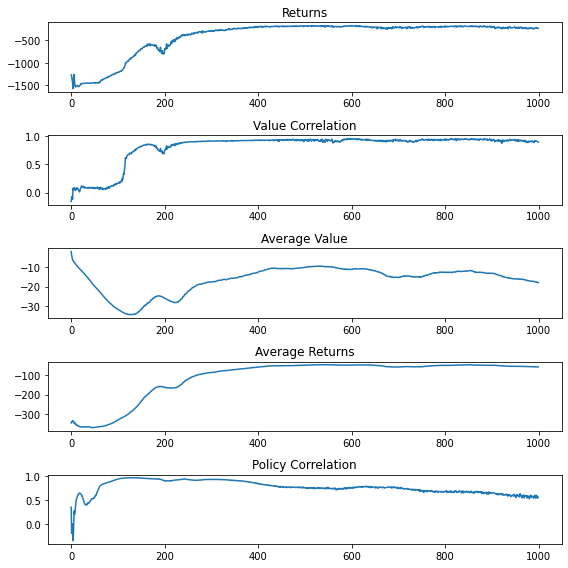

In [ ]:
f, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 8))
for i, (key, value) in enumerate(metrics.items()):
    axes[i].plot(value)
    axes[i].set_title(key)
plt.tight_layout()

## AWR

In [ ]:
class AWR:
    def __init__(self, policy, value, replay_buffer, num_value_steps: int, 
                 num_policy_steps: int, alpha: float, discount: float, 
                 beta: float, score_max: float, batch_size: int):
        super().__init__()
        self.replay_buffer = replay_buffer
        self.batch_size = batch_size
        self.num_value_steps = tf.constant(num_value_steps, tf.int64)
        self.num_policy_steps = tf.constant(num_policy_steps, tf.int64)
        self.alpha = tf.constant(alpha, tf.float32)
        self.discount = tf.constant(discount, tf.float32)
        self.beta = tf.constant(beta, tf.float32)
        self.score_max = tf.constant(score_max, tf.float32)
        self.policy = policy
        self.value = value
        self.mse = tf.keras.losses.MeanSquaredError()
        self.policy_optimizer = tf.keras.optimizers.Adam()
        self.value_optimizer = tf.keras.optimizers.Adam()

    def initialize(self) -> None:
        observations = tf.zeros([1, 3], tf.float32)
        self.policy.conditional(observations)
        self.value(observations) 

    def update(self) -> None:
        if tf.cast(self.replay_buffer.count, tf.int64) >= self.batch_size:
            replay_dataset = self.replay_buffer.dataset()
            replay_dataset_value = (
                replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
                .repeat(-1)
                .batch(self.batch_size)
                .prefetch(-1))
            replay_dataset_value_iter = iter(replay_dataset_value)
            replay_dataset_policy = (
                replay_dataset.shuffle(tf.cast(self.replay_buffer.count, tf.int64))
                .repeat(-1)
                .batch(self.batch_size)
                .prefetch(-1))
            replay_dataset_policy_iter = iter(replay_dataset_policy)

            # Fit the value
            for _ in tf.range(self.num_value_steps):
                (observations, actions, rewards, next_observation, 
                next_action) = next(replay_dataset_value_iter)

                # Compute returns
                bootstrap_value = self.value(next_observation)
                returns = discounted_returns(tf.reduce_sum(rewards, axis=-1)[..., None], 
                                            discount=self.discount, 
                                            bootstrap_value=bootstrap_value)

                with tf.GradientTape() as tape:
                    values = self.value(observations, training=tf.constant(True))
                    value_loss = .5 * self.mse(returns, values)
                value_gradients = tape.gradient(value_loss, 
                                                self.value.trainable_variables)
                self.value_optimizer.apply_gradients(
                    zip(value_gradients, self.value.trainable_variables))

            # Fit the policy
            for _ in tf.range(self.num_policy_steps):
                (observations, actions, rewards, next_observation, 
                next_action) = next(replay_dataset_policy_iter)

                bootstrap_value = self.value(next_observation)
                returns = discounted_returns(tf.reduce_sum(rewards, axis=-1)[..., None], 
                                            discount=self.discount, 
                                            bootstrap_value=bootstrap_value)

                # Compute advantages
                values = self.value(observations)
                advantages = tf.squeeze(returns - values, axis=-1)
                advantages = tf.minimum(tf.exp(advantages / self.beta), 
                                        self.score_max)

                with tf.GradientTape() as tape:
                    distribution = self.policy.conditional(
                        observations, 
                        training=tf.constant(True))
                    log_prob = distribution.log_prob(actions)
                    score = log_prob * advantages
                    entropy = tf.reduce_mean(distribution.entropy())
                    policy_loss = -(tf.reduce_mean(score) + self.alpha * entropy)
                policy_gradients = tape.gradient(policy_loss, 
                                                self.policy.trainable_variables)
                self.policy_optimizer.apply_gradients(
                    zip(policy_gradients, self.policy.trainable_variables))

        # Metrics.
        (observations, actions, rewards, next_observation, _) = self.replay_buffer.get()
        next_observations = tf.concat([observations[:, 1:], next_observation[:, None]], axis=1)
        bootstrap_values = self.value(next_observations)
        returns = tf.reduce_sum(rewards, axis=-1)[..., None] + self.discount * bootstrap_values

        # Compute advantages
        values = self.value(observations)
        advantages = tf.squeeze(returns - values, axis=-1)

        # These tend to be exploding, so we clip.
        advantages = tf.clip_by_value(advantages, -1., 1.)

        # Measure weighted correlation.
        distribution = self.policy.conditional(observations, training=tf.constant(False))
        policy_actions = distribution.mode()
        policy_correlation = weighted_correlation(
            tf.squeeze(actions, axis=-1), 
            tf.squeeze(policy_actions, axis=-1), 
            scale(advantages, axis=[0, 1]), 
            sample_axis=[0, 1])

        average_value = tf.reduce_mean(values)
        average_returns = tf.reduce_mean(tf.reduce_sum(rewards, axis=[1, 2]), axis=0)

        return average_value, average_returns, policy_correlation 

### Fit

In [ ]:
batch_size = 250
n_step = 50
replay_buffer = ReplayBuffer(
    10000, Transition(
        observation=tf.TensorSpec([n_step, 3]), 
        action=tf.TensorSpec([n_step, 1]), 
        reward=tf.TensorSpec([n_step, 3]), 
        next_observation=tf.TensorSpec([3]), 
        next_action=tf.TensorSpec([1], tf.float32)))
mdp = PendulumEnv()
policy = MVNPolicy()
value = Value()

discount = 1 - (1 / n_step)
agent = AWR(policy, value, replay_buffer, 50, 50, 0.001, discount, 1., 20., batch_size)
agent.update = tf.function(agent.update)

reset_every = 200 // n_step
explore_agent = ExplorePendulumAgent(policy)
exploit_agent = ExploitPendulumAgent(policy)
explore_rollout = PendulumRollout(mdp, explore_agent)
explore_rollout.unroll = tf.function(explore_rollout.unroll)
exploit_rollout = PendulumRollout(mdp, exploit_agent)
exploit_rollout.unroll = tf.function(exploit_rollout.unroll)

valid_state = mdp.get_initial_state_distribution().sample(100)
state = mdp.get_initial_state_distribution().sample(batch_size)

metrics = {
    "Returns": [],
    "Value Correlation": [],
    "Average Value": [],
    "Average Returns": [],
    "Policy Correlation": [],
}

for i in range(1000):
    state, transition = explore_rollout.unroll(state, n_step)
    if (i + 1) % reset_every == 0:
        state = mdp.get_initial_state_distribution().sample(batch_size)
    replay_buffer.update(transition)
    average_value, average_returns, policy_correlation = agent.update()
    _, transition = explore_rollout.unroll(valid_state, 200)

    # Output some metrics.
    reward = tf.reduce_sum(transition.reward, axis=-1)
    returns = tf.reduce_mean(tf.reduce_sum(reward, axis=1), axis=0).numpy()
    n_step_undiscounted_returns = tf.reduce_sum(
        tf.signal.frame(reward, n_step, 1, pad_end=True, axis=1), axis=2)
    n_step_undiscounted_returns = tf.reshape(n_step_undiscounted_returns, [-1])
    values = tf.reshape(value(transition.observation), [-1])
    value_correlation = tfp.stats.correlation(values, n_step_undiscounted_returns, sample_axis=0, event_axis=None).numpy()
    print(f"G={returns},r={value_correlation}")

    metrics["Returns"].append(returns)
    metrics["Value Correlation"].append(value_correlation)
    metrics["Average Value"].append(average_value)
    metrics["Average Returns"].append(average_returns)
    metrics["Policy Correlation"].append(policy_correlation)

G=-1499.149169921875,r=-0.06923343241214752
G=-1369.99462890625,r=-0.10572860389947891
G=-1348.1126708984375,r=-0.08878439664840698
G=-1330.29052734375,r=-0.0945514440536499
G=-1398.1307373046875,r=-0.07396185398101807
G=-1363.2315673828125,r=-0.09470972418785095
G=-1357.25146484375,r=-0.08361928164958954
G=-1374.145751953125,r=-0.06783269345760345
G=-1315.2332763671875,r=-0.08380088955163956
G=-1356.6619873046875,r=-0.06631240248680115
G=-1322.376220703125,r=-0.06671477854251862
G=-1303.6204833984375,r=-0.05528322607278824
G=-1316.6605224609375,r=-0.05432320386171341
G=-1288.5001220703125,r=-0.03171280398964882
G=-1332.724365234375,r=-0.018094228580594063
G=-1316.453125,r=-0.022890016436576843
G=-1339.8140869140625,r=-0.04589561000466347
G=-1330.978271484375,r=-0.009069828316569328
G=-1313.1043701171875,r=-0.0006893958779983222
G=-1327.581298828125,r=-0.009508464485406876
G=-1331.3414306640625,r=0.01560044102370739
G=-1334.8516845703125,r=0.025523614138364792
G=-1278.463623046875,r=0.

### Analysis of the fit

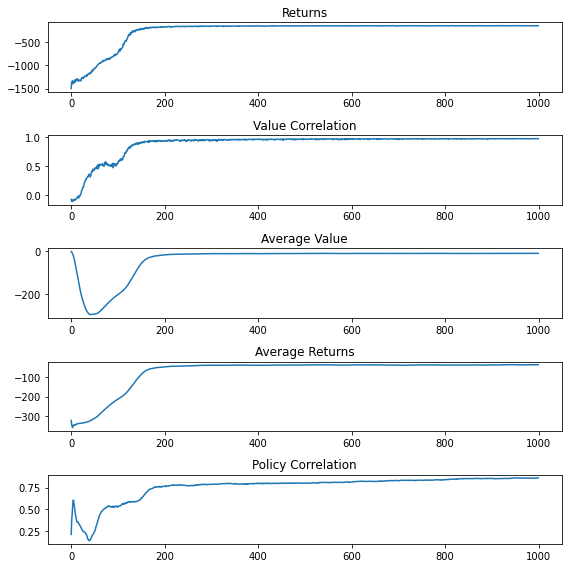

In [ ]:
f, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 8))
for i, (key, value) in enumerate(metrics.items()):
    axes[i].plot(value)
    axes[i].set_title(key)
plt.tight_layout()